## Analysis of publications related to OpenNeuro

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as tkr
datadir = '../data/openneuro'
figdir = '../figures'

plt.rc('font', family='Helvetica')

In [2]:
metadata = pd.read_csv(os.path.join(datadir, 'metadata_sheet.csv'), skiprows=1)
rename_dict = {'Assession Number': 'AccessionNumber',
              'Dataset made public (MM/DD/YYYY)': 'ReleaseDate',
              '# of subjects': 'NSubjects',
              'Species?': 'Species',
              'Modalities available?': 'Modalities'}
metadata = metadata.rename(rename_dict, axis=1)

In [3]:
metadata.columns

Index(['AccessionNumber', 'Dataset URL', 'Dataset name', 'ReleaseDate',
       'Most recent snapshot date (MM/DD/YYYY)', 'NSubjects', 'Modalities',
       'DX status(es)', 'Ages (range)', 'Tasks completed?',
       '# of trials (if applicable)', 'Study design', 'Domain studied',
       'Longitudinal?', 'Processed data?', 'Species',
       'DOI of paper associated with DS (from submitter lab)',
       'DOI of paper because DS on OpenNeuro',
       'Senior Author (lab that collected data) Last, First'],
      dtype='object')

In [4]:
metadata['ReleaseDate'] = pd.to_datetime(metadata['ReleaseDate'])

# Collapse any dates prior to 07/17/2018 when OpenfMRI datasets were uploaded
#metadata.loc[metadata["ReleaseDate"] < "2018-07-17", "ReleaseDate"] = "2018-07-17"

## Statistics on the database

In [5]:
print('Number of datasets:', len(metadata['Dataset name'].unique()))
print('Number of datasets:', len(metadata['AccessionNumber'].unique()))


Number of datasets: 740
Number of datasets: 754


In [6]:
print('Number of subjets:', metadata['NSubjects'].sum())


Number of subjets: 30347


In [78]:
data_paper_dois = metadata['DOI of paper associated with DS (from submitter lab)'].unique()
print(f'Number of data paper DOIs: {data_paper_dois.shape[0]}')
print(f'Proportion of data paper DOIs: {data_paper_dois.shape[0]/metadata.shape[0]}')

Number of data paper DOIs: 444
Proportion of data paper DOIs: 0.5880794701986755


In [79]:
user_paper_dois = metadata['DOI of paper because DS on OpenNeuro'].unique()
print(f'Number of user paper DOIs: {user_paper_dois.shape[0]}')

Number of user paper DOIs: 50


Clean up data to create plots

In [80]:
df_sorted = metadata.sort_values('ReleaseDate')
df_sorted['ones'] = 1
df_sorted['cumulative'] = df_sorted['ones'].cumsum()
df_sorted['cumulative_subjects'] = df_sorted['NSubjects'].cumsum()
dates = df_sorted['ReleaseDate'].unique()
print('Earliest dataset:', dates.min())
print('Latest dataset:', dates.max())

# fix dates to reflect fact that early datasets were all from openneuro
#df_sorted.loc[df_sorted['ReleaseDate'] < pd.Timestamp(2018,8,1), 'ReleaseDate'] = '2018-08-01'
df_sorted

Earliest dataset: 2018-07-13T00:00:00.000000000
Latest dataset: 2022-08-22T00:00:00.000000000


,AccessionNumber,Dataset URL,Dataset name,ReleaseDate,Most recent snapshot date (MM/DD/YYYY),NSubjects,Modalities,DX status(es),Ages (range),Tasks completed?,...,Domain studied,Longitudinal?,Processed data?,Species,DOI of paper associated with DS (from submitter lab),DOI of paper because DS on OpenNeuro,"Senior Author (lab that collected data) Last, First",ones,cumulative,cumulative_subjects
0,ds000001,https://openneuro.org/datasets/ds000001/versio...,Balloon Analog Risk-taking Task,2018-07-13,7/13/2018,16,"MRI - anat, MRI - func",Healthy/Control,"18-25, 26-34",Ballon Analog Risk Task,...,"Risk-taking, Decision-making",No,No,Human,10.3389/fnins.2012.00080,NaN,"Poldrack, Russ",1,1,16
30,ds000122,https://openneuro.org/datasets/ds000122/versio...,Task-related concurrent but opposite modulatio...,2018-07-13,7/13/2018,17,"MRI - anat, MRI - func",Healthy/Control,"18-25, 26-34, 35-50",visual attention task,...,overlapping functional networks,No,Yes,Human,10.1016/j.neuroimage.2013.04.038,NaN,"Potenza, Marc N.",1,2,33
24,ds000115,https://openneuro.org/datasets/ds000115/versio...,Working memory in healthy and schizophrenic in...,2018-07-13,7/13/2018,99,"MRI - anat, MRI - func","Healthy/Control, Schizophrenia, Siblings of co...","11-17, 18-25, 26-34","letter 0-back task, letter 1-back task, letter...",...,"Working Memory, Schizophrenia",No,No,Human,10.3389/fnhum.2012.00137,"https://arxiv.org/pdf/1911.01898.pdf, 10.1016/...","Barch, Deanna M.",1,3,132
91,ds001021,https://openneuro.org/datasets/ds001021/versio...,NKI-sample,2018-07-13,8/15/2018,1,"MRI - anat, MRI - func, MRI - dwi",Healthy/Control,51-65,"BREATH_HOLD_1400, CHECKERBOARD_1400, CHECKERBO...",...,NKI_Sample,No,No,Human,NaN,NaN,"Milham, Michael",1,4,133
21,ds000110,https://openneuro.org/datasets/ds000110/versio...,Incidental encoding task (Posner Cueing Paradigm),2018-07-13,7/13/2018,18,"MRI - anat, MRI - func",Healthy/Control,"18-25, 26-34",Incidental encoding,...,episodic memory,No,Yes,Human,10.1523/JNEUROSCI.0152-11.2011,NaN,"Wagner, Anthony",1,5,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,ds004197,https://openneuro.org/datasets/ds004197/versio...,FMRI-EEG Prestudy,2022-08-18,8/18/2022,4,"MRI - func, MRI - anat, EEG",Healthy / Control,NaN,InnerSpeech,...,Inner Speech,No,No,Human,doi: https://doi.org/10.1101/2022.05.24.492109,NaN,"Eriksson, Johan",1,751,30245
728,ds004145,https://openneuro.org/datasets/ds004145/versio...,GDMOffspring_MRI,2022-08-19,8/19/2022,49,MRI - anat,Gestational diabetes,NaN,NaN,...,Diabetes,No,No,Mouse,NaN,NaN,"Jung, Sangyong",1,752,30294
753,ds004253,https://openneuro.org/datasets/ds004253/versio...,HCP Unrelated 100 Subset (HCP-30),2022-08-19,8/19/2022,30,MRI - anat,NaN,NaN,NaN,...,NaN,No,No,Human,10.1016/j.neuroimage.2013.05.041,NaN,"Consortium, WU-Minn HCP",1,753,30324
719,ds004127,https://openneuro.org/datasets/ds004127/versio...,Somatosensory Cortex Rat DISC Data,2022-08-22,8/22/2022,8,iEEG,NaN,NaN,NaN,...,NaN,No,No,Rat,https://doi.org/10.1101/2021.09.20.460996,1,"Seymour, John P",1,754,30332


In [81]:
from collections import defaultdict

datasets = defaultdict(lambda: 0)
subjects = defaultdict(lambda: 0)

for date, nsub in metadata[["ReleaseDate", "NSubjects"]].values:
    datasets[date.strftime('%Y-%m-%d')] += 1
    subjects[date.strftime('%Y-%m-%d')] += nsub

datadict = defaultdict(list)
for k in datasets.keys():
    datadict["ReleaseDate"].append(k)
    datadict["n_datasets"].append(datasets[k])
    datadict["n_subjects"].append(subjects[k])
    
df_plotting = pd.DataFrame(datadict)
df_plotting['ReleaseDate'] = pd.to_datetime(df_plotting['ReleaseDate'])
df_plotting = df_plotting.set_index("ReleaseDate").sort_values(by="ReleaseDate")

df_plotting["cumsum_datasets"] = df_plotting['n_datasets'].cumsum()
df_plotting['cumsum_subjects'] = df_plotting['n_subjects'].cumsum()

release_dates = df_plotting.index.astype(int)

df_plotting

,n_datasets,n_subjects,cumsum_datasets,cumsum_subjects
ReleaseDate,,,,
2018-07-13,26,570,26,570
2018-07-14,6,142,32,712
2018-07-15,18,489,50,1201
2018-07-16,30,1319,80,2520
2018-07-17,36,1396,116,3916
...,...,...,...,...
2022-08-16,1,13,749,30240
2022-08-17,1,1,750,30241
2022-08-18,1,4,751,30245


In [82]:
print(f"OpenNeuro surpassed the 10k datasets on {df_plotting[df_plotting['cumsum_subjects'] > 10000].index[0].strftime('%B %d, %Y')}")
print(f"The latest report from {df_plotting.index[-1].strftime('%B %d, %Y')} yields {df_plotting['cumsum_datasets'].iloc[-1]} datasets, and {df_plotting['cumsum_subjects'].iloc[-1]} subjects")

OpenNeuro surpassed the 10k datasets on March 19, 2020
The latest report from August 22, 2022 yields 755 datasets, and 30347 subjects


In [116]:
midyears = pd.to_datetime([f"20{yr}-07-02" for yr in range(18, 23)]).astype(int)  # July 2 is the midpoint of year

Plot # of datasets over time

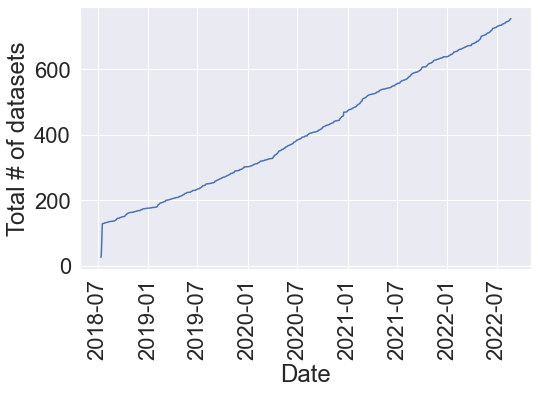

In [84]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2)  # crazy big
sns.lineplot(x='ReleaseDate', y='cumsum_datasets', data=df_plotting)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Total # of datasets')
plt.tight_layout()
# plt.savefig(os.path.join(figdir, 'n_datasets.pdf'))

Plot # of subjects over time

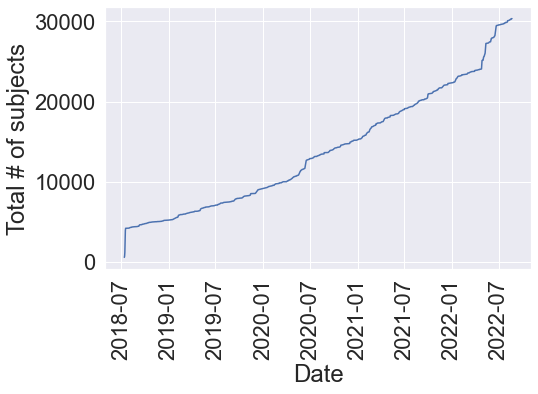

In [85]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2)  # crazy big
sns.lineplot(x='ReleaseDate', y='cumsum_subjects', data=df_plotting)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Total # of subjects')
plt.tight_layout()
# plt.savefig(os.path.join(figdir, 'n_subjects.pdf'))

Plot both together

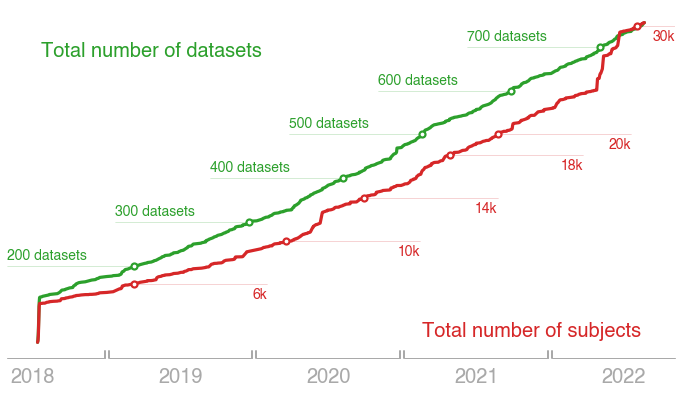

In [118]:
# Edit general skin
sns.set_style('whitegrid')
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot Datasets
color = 'tab:green'
ax1.set_xlabel('Date', fontsize=20, fontname="Helvetica")
ax1 = sns.lineplot(x=release_dates, y=df_plotting['cumsum_datasets'], 
                   color=color, label='Datasets', linewidth=3.2)
# Plot Subjects
ax2 = ax1.twinx()
color = 'tab:red'
ax2 = sns.lineplot(x=release_dates, y=df_plotting['cumsum_subjects'],
                   color=color, label='Subjects', linewidth=3.2)
# Grid & spines
ax1.grid(False)
ax2.grid(False)
ax1.spines.left.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.spines.right.set_visible(False)
ax2.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.spines.bottom.set_visible(False)
ax2.spines.bottom.set_visible(False)
# ax1.spines.bottom.set_position(('outward', 10))

# Manipulate axes
ax1.set_ylabel(None)
ax2.set_ylabel(None)
ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax1.get_legend().remove()
ax2.get_legend().remove()

# Place year label at the middle of each year
ax1.set_xticks(midyears)
ax1.set_xticklabels([f"20{yr}" for yr in range(18, 23)], fontname="Helvetica", fontsize=20, color="darkgray")

# Annotate total datasets
x_lim = ax1.get_xlim()
y1_lim = ax1.get_ylim()
normalized_dates = (release_dates - x_lim[0]) / (x_lim[1] - x_lim[0])
num_ds = [200, 300, 400, 500, 600, 700]
x_dates_norm = np.interp(num_ds, df_plotting['cumsum_datasets'], normalized_dates)
x_dates = np.interp(num_ds, df_plotting["cumsum_datasets"], release_dates)
y1_norm = (np.array(num_ds) - y1_lim[0]) / (y1_lim[1] - y1_lim[0])

for y, x, y_norm in zip(num_ds, x_dates_norm, y1_norm):
    xorig = max(x - 0.2, 0)
    ax1.axhline(y=y, xmax=x, xmin=xorig, color='tab:green', alpha=0.4, linewidth=0.5)
    ax1.text(xorig, y_norm + 0.01, f"{y} datasets",
             transform=ax1.transAxes,
             verticalalignment='bottom', horizontalalignment='left',
             color='tab:green', fontname="Helvetica", fontsize=14)

ax1.plot(
    x_dates,
    num_ds,
    marker="o",
    markeredgecolor="tab:green",
    markerfacecolor="white",
    color="white",
    ms=6,
    markeredgewidth=2.2,
    fillstyle="full",
    linestyle="None",
)
    
# Annotate total subjects
num_subj = [6000, 10000, 14000, 18000, 20000, 30000]
x_subj_dates = np.interp(num_subj, df_plotting['cumsum_subjects'], normalized_dates)
x2_dates = np.interp(num_subj, df_plotting["cumsum_subjects"], release_dates)
y2_lim = ax2.get_ylim()
y2_norm = (np.array(num_subj) - y2_lim[0]) / (y2_lim[1] - y2_lim[0])
for y, x, y_norm in zip(num_subj, x_subj_dates, y2_norm):
    xend = min(x + 0.2, 1.0)
    ax2.axhline(y=y, xmin=x, xmax=xend, color='tab:red', alpha=0.4, linewidth=0.5)
    ax2.text(xend, y_norm - 0.01, f"{y // 1000}k",
             transform=ax2.transAxes,
             verticalalignment='top', horizontalalignment='right',
             color='tab:red', fontname="Helvetica", fontsize=14)
    
ax2.plot(
    np.interp(num_subj, df_plotting["cumsum_subjects"], release_dates),
    num_subj,
    marker="o",
    markeredgecolor="tab:red",
    markerfacecolor="white",
    color="white",
    ms=6,
    markeredgewidth=2.2,
    fillstyle="full",
    linestyle="None",
)

# Add Y-axis labels in the middle of the plot, linked by color
ax2.text(0.05, 0.9, 'Total number of datasets',
         verticalalignment='top', horizontalalignment='left',
         transform=ax2.transAxes,
         color='tab:green', fontname="Helvetica", fontsize=20)

ax2.text(0.95, 0.05, 'Total number of subjects',
         verticalalignment='bottom', horizontalalignment='right',
         transform=ax2.transAxes,
         color='tab:red', fontname="Helvetica", fontsize=20)

# Replace X-axis with a fancier timeline plot
years = pd.to_datetime(["2018-01-05", "2018-12-26",
                    "2019-01-05", "2019-12-26",
                    "2020-01-05", "2020-12-26",
                    "2021-01-05", "2021-12-26",
                    '2022-01-05', '2022-12-26']).astype(int).values
years_norm = (years - x_lim[0]) / (x_lim[1] - x_lim[0])
years_norm[0] = 0.0
years_norm[-1] = 1.0

for yr_start, yr_end in years_norm.reshape(-1, 2):
    ax1.axhline(
        y1_lim[0],
        xmin=yr_start,
        xmax=yr_end,
        clip_on=False,
        color="darkgray",
        linewidth=1,
    )

for yr in years[1:-1]:
    ax1.axvline(
        yr,
        ymin=0,
        ymax=0.02,
        clip_on=False,
        color="darkgray",
        linewidth=2,
    )        
        
ax1.set_yticks([])
ax2.set_yticks([])
        
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'combined_growth.png'))
plt.savefig(os.path.join(figdir, 'combined_growth.pdf'))

## analysis of data types: species

In [129]:
# clean up labels
cleanup_dict = {'Mice': 'Mouse',
               'Rats': 'Rat',
                'rat': 'Rat',
                'Adult Wistar rats': 'Rat',
               'C57bl/6 mixed gender mice': 'Mouse',
               'mouse': 'Mouse',
               'Macaque': 'NHP',
               'mouse lemur': 'NHP'}

species_counts_clean = {'Mouse': 0,
                        'Rat': 0,
                       'Human': 0,
                       'Phantom': 0,
                       'NHP': 0}

for idx in df_sorted.index:
    if df_sorted.loc[idx,'Species'] in cleanup_dict:
        df_sorted.loc[idx, 'Species'] = cleanup_dict[df_sorted.loc[idx,'Species']]

species_counts = df_sorted['Species'].value_counts()
for i in range(species_counts.loc['Mice and Rats']):
    species_counts.loc['Mouse'] = species_counts.loc['Mouse'] + 1
    species_counts.loc['Rat'] = species_counts.loc['Rat'] + 1
species_counts.drop('Mice and Rats', inplace=True)
print('Total # of datasets:', species_counts.sum())
for i in species_counts.to_markdown().split('\n'):
    print(i)

Total # of datasets: 716
|               |   Species |
|:--------------|----------:|
| Human         |       676 |
| Mouse         |        20 |
| Rat           |        12 |
| NHP           |         2 |
| phantoms      |         1 |
| Juvenile pigs |         1 |
| Human, Mouse  |         1 |
| Dog           |         1 |
| Monkey        |         1 |
| Sheep         |         1 |


In [88]:
species_counts/species_counts.sum()

Human            0.944134
Mouse            0.027933
Rat              0.016760
NHP              0.002793
phantoms         0.001397
Juvenile pigs    0.001397
Human, Mouse     0.001397
Dog              0.001397
Monkey           0.001397
Sheep            0.001397
Name: Species, dtype: float64

## analysis of data types: modality

In [89]:

modalities = df_sorted['Modalities'].dropna()

mod_list = defaultdict(lambda: 0)

for i in modalities:
    for k in i.split(','):
        k = k.lstrip().lower()
        mod_list[k] = mod_list[k] + 1

In [127]:
mod_df = pd.Series(mod_list)
md = mod_df.sort_values(ascending=False).to_markdown()
for i in md.split('\n'):
    print(i)

|             |   0 |
|:------------|----:|
| mri - anat  | 597 |
| mri - func  | 521 |
| eeg         | 120 |
| field map   |  81 |
| mri - dwi   |  67 |
| fieldmap    |  40 |
| meg         |  30 |
| ieeg        |  17 |
| beh         |  13 |
| pet         |  11 |
| t1w         |   7 |
| bold        |   7 |
| events      |   7 |
| asl         |   3 |
| mri - perf  |   3 |
| fmap        |   2 |
| sbref       |   2 |
| physio      |   1 |
| t1map       |   1 |
| ute         |   1 |
| t2w         |   1 |
| motion      |   1 |
| swi         |   1 |
| dixon       |   1 |
| field map   |   1 |
| calibration |   1 |
| eyetrack    |   1 |
| stat        |   1 |
| fieldmaps   |   1 |
| angiography |   1 |
| venograms   |   1 |
| angiograms  |   1 |
| epi         |   1 |


## Analysis of dataset size

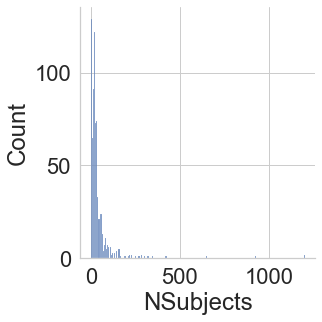

In [91]:
# number of subjects
import numpy as np
df_sorted['nsubs'] = df_sorted['NSubjects']
nsubs = df_sorted.query('nsubs > 0')['NSubjects']
sns.displot(nsubs) #, log_scale=True)

In [92]:
print('median # of subjects:', nsubs.median())


median # of subjects: 23.0


In [93]:
print('# of datasets with more than 100 subjects', (nsubs > 100).sum())

# of datasets with more than 100 subjects 45


In [94]:
print('maximum dataset size:', nsubs.max())

maximum dataset size: 1202


## Analysis of sessions

Using data obtained from datalad datasets

In [95]:
datalad_metadata = pd.read_csv('../data/openneuro/ds_info.csv')
datalad_metadata.head()

,Unnamed: 0,dsnum,ntasks,nsessions,nsubs,tasknames
0,0,ds000001,1,1,16,{'balloon analog risk task'}
1,1,ds000002,3,1,17,"{'probabilistic classification', 'mixed event-..."
2,2,ds000003,1,1,13,{'rhyme judgment'}
3,3,ds000005,1,1,16,{'mixed-gambles task'}
4,4,ds000006,1,2,14,{'living-nonliving decision with plain or mirr...


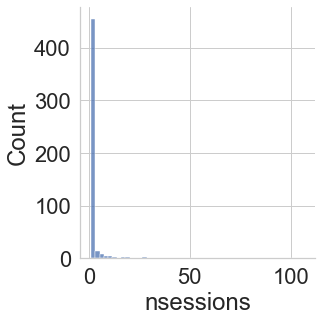

In [96]:
sns.displot(datalad_metadata.nsessions, bins=50)

In [97]:
print('max # of sessions:', datalad_metadata.nsessions.max())
print('# of datasets with more than 1 session:', (datalad_metadata.nsessions > 1).sum())


max # of sessions: 107
# of datasets with more than 1 session: 128


In [98]:
# further analysis of tasks is done in task_analysis.ipynb
print('max # of tasks:', datalad_metadata.ntasks.max())
print('# of datasets with more than 1 task:', (datalad_metadata.ntasks > 1).sum())


max # of tasks: 48
# of datasets with more than 1 task: 202


## Analysis of publications

In [99]:
print('Proportion of papers with a DOI:',
      df_sorted['DOI of paper associated with DS (from submitter lab)'].dropna().shape[0]/df_sorted.shape[0])

Proportion of papers with a DOI: 0.623841059602649


In [100]:
dois = []
multi_doi = 0
for i in df_sorted['DOI of paper associated with DS (from submitter lab)'].dropna():
    i_s = i.split(',')
    if len(i_s) > 1:
        multi_doi += 1
    dois = dois + i_s
    
print('# of papers associated with more than one DOI:', multi_doi)
print('# of unique DOIs:', len(set(dois)))

# of papers associated with more than one DOI: 69
# of unique DOIs: 643


## figure showing width/breadth/depth

In [101]:
datalad_metadata.shape

(502, 6)

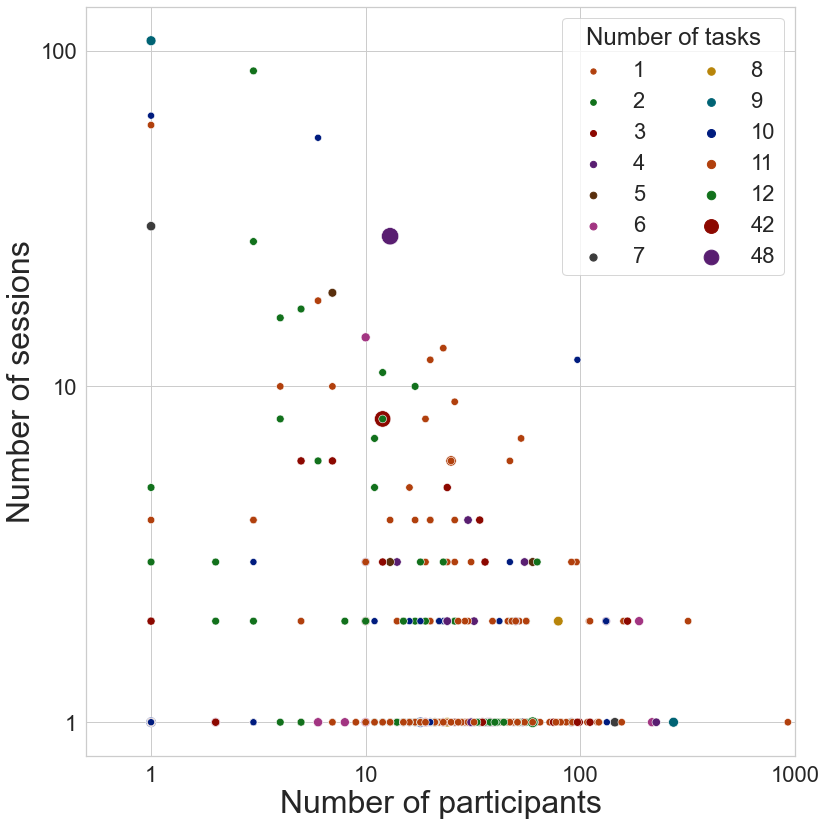

In [119]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 12))
splot = sns.scatterplot(x='nsubs', y='nsessions', size='ntasks', hue='ntasks',
                         data=datalad_metadata,
                        sizes=(50, 300), palette="dark",
                        legend = 'brief')

splot.set(xscale="log")
splot.set(yscale="log")
plt.xlim([.5, 1000])
plt.xlabel('Number of participants', fontsize=32)
plt.ylabel('Number of sessions', fontsize=32)

leg = splot.axes.get_legend()
new_title = '# of tasks'
leg.set_title(new_title)

for axis in [splot.xaxis, splot.yaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)

handles, labels = splot.get_legend_handles_labels()
for i, h in enumerate(handles[1:15]):
    h.set_sizes([24 + int(labels[i+1])*4])
splot.legend(handles=handles[1:15], labels=labels[1:15], loc=1, 
            ncol=2, bbox_to_anchor=(1,1), title='Number of tasks')
plt.tight_layout()
plt.savefig('../figures/dataset_size.pdf')


In [103]:
dir(handles[0])

['_A',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_antialiaseds',
 '_axes',
 '_bcast_lwls',
 '_callbacks',
 '_capstyle',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_default_contains',
 '_edge_default',
 '_edge_is_mapped',
 '_edgecolors',
 '_face_is_mapped',
 '_facecolors',
 '_factor',
 '_get_clipping_extent_bbox',
 '_get_default_antialiased',
 '_get_default_edgecolor',
 '_get_default_facecolor',
 '_get_default_linewidth',
 '_gid',
 '_hatch',
 '_hatch_color',
 '_id_norm',
 '_in_layout',
 '_joinstyle',
 '_label',
 '_linestyles',
 '_linewidths',
 '_mapped_colors',

In [104]:
labels

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '42',
 '48',
 '0',
 '8',
 '16',
 '24',
 '32',
 '40',
 '48']